In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import warnings
import torch
import random
from IPython import display
from matplotlib import pyplot as plt
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn
warnings.filterwarnings("ignore")

In [ ]:
# 定义dataset
class my_Dataset(data.Dataset):
  def __init__(self, features, labels):
    self.X = features
    self.y = labels

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.X.shape[0]

In [ ]:
class TrafficDataset:
  def __init__(self, sensor=10, target=0):
    # 选取适当的检测器用作序列数据
    self.raw_data = np.load('/content/traffic.npz')['data']
    self.sensor = sensor
    self.target = target
    # 数据标准化
    self.min = self.raw_data.min()
    self.max = self.raw_data.max()
    self.data = (self.raw_data - self.min) / (self.max - self.min)

  def denormalize(self, x):
    return x * (self.max - self.min) + self.min

  def construct_set(self, train_por = 0.6, test_por = 0.2, window_size = 12, label=0):
    # 预测车流量 选取1号传感器，滑动窗口大小设置为12
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    test_x = []
    test_y = []
    sensor_num = 1

    # 补全构造过程
    #训练集
    len_train = int(self.data.shape[0] * train_por)
    train_seqs = self.data[:len_train]
    for i in range(train_seqs.shape[0] - window_size):
      train_x.append(train_seqs[i:i + window_size, sensor_num, :].squeeze())
      train_y.append(train_seqs[i + window_size, sensor_num, label].squeeze())

    # train_x = torch.Tensor(train_x)
    # train_y = torch.Tensor(train_y)
    #验证集
    len_val = int(self.data.shape[0] * (train_por+test_por))
    val_seqs = self.data[len_train:len_val]
    for i in range(val_seqs.shape[0] - window_size):
      val_x.append(val_seqs[i:i + window_size, sensor_num, :].squeeze())
      val_y.append(val_seqs[i + window_size, sensor_num, label].squeeze())

    # val_x = torch.Tensor(val_x)
    # val_y = torch.Tensor(val_y)
    #测试集
    test_seqs = self.data[len_val:]
    for i in range(test_seqs.shape[0] - window_size):
      test_x.append(test_seqs[i:i + window_size, sensor_num, :].squeeze())
      test_y.append(test_seqs[i + window_size, sensor_num, label].squeeze())

    # test_x = torch.Tensor(test_x)
    # test_y = torch.Tensor(test_y)

    train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
    val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
    test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
    return train_set, val_set, test_set

In [ ]:
def mape_fn(y, pred):
  mask = y != 0
  y = y[mask]
  pred = pred[mask]
  mape = np.abs((y - pred) / y)
  mape = np.mean(mape) * 100
  return mape


def eval(y, pred):
  y = y.cpu().numpy()
  pred = pred.cpu().numpy()
  mse = mse_fn(y, pred)
  rmse = math.sqrt(mse)
  mae = mae_fn(y, pred)
  mape = mape_fn(y, pred)
  return [rmse, mae, mape]


In [ ]:
def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
  x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
  plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
  plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()


def plot_metric(score_log):
  score_log = np.array(score_log)

  plt.figure(figsize=(10, 6), dpi=300)
  plt.subplot(2, 2, 1)
  plt.plot(score_log[:, 0], c='#d28ad4')
  plt.ylabel('RMSE')

  plt.subplot(2, 2, 2)
  plt.plot(score_log[:, 1], c='#e765eb')
  plt.ylabel('MAE')

  plt.subplot(2, 2, 3)
  plt.plot(score_log[:, 2], c='#6b016d')
  plt.ylabel('MAPE')

  plt.show()


In [ ]:
class MyRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    """
    :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
    :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
    :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
    """
    super().__init__()
    self.hidden_size = hidden_size
        
    # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
    self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
    self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
    self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
    self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
    self.b_y = nn.Parameter(torch.zeros(output_size))
        
    # 准备激活函数。Dropout函数可选。
    self.tanh = nn.Tanh()
    self.leaky_relu = nn.LeakyReLU()
        
    # 可选：使用性能更好的参数初始化函数
    for param in self.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)
                
  def forward(self, x):
    """
    :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
    """
    batch_size = x.size(0)
    seq_len = x.size(1)
        
    # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
    h = torch.zeros(batch_size, self.hidden_size).to(x.device)
    # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
    y_list = []
    for i in range(seq_len):
      h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
      y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
      y_list.append(y)
    # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
    return torch.stack(y_list, dim=1), h

In [ ]:
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

In [ ]:
def mape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  non_zero_index = (y_true > 0)
  y_true = y_true[non_zero_index]
  y_pred = y_pred[non_zero_index]

  mape = np.abs((y_true - y_pred) / y_true)
  mape[np.isinf(mape)] = 0
  return np.mean(mape) * 100

In [ ]:
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
  rmse, mae, mape = 0, 0, 0
  batch_count = 0
  total_loss = 0.0
  net.eval()
  if output_model is not None:
    output_model.eval()
  for X, Y in data_iter:
    X = X.to(device).float()
    Y = Y.to(device).float()
    output, hidden = net(X)
    if output_model is not None:
      y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
    else:
      y_hat = output[:, -1, :].squeeze(-1)
    loss = loss_fn(y_hat, Y)

    Y = denormalize_fn(Y)
    y_hat = denormalize_fn(y_hat)
    a, b, c = eval(Y.detach(), y_hat.detach())
    rmse += a
    mae += b
    mape += c
    total_loss += loss.detach().cpu().numpy().tolist()
    batch_count += 1
  return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count

In [ ]:
def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
  train_loss_lst = []
  val_loss_lst = []
  train_score_lst = []
  val_score_lst = []
  epoch_time = []

  best_epoch = 0
  best_val_rmse = 9999
  early_stop_flag = 0
  for epoch in range(num_epoch):
    net.train()
    if output_model is not None:
      output_model.train()
    epoch_loss = 0
    batch_count = 0
    batch_time = []
    rmse, mae, mape = 0, 0, 0
    for X, Y in train_iter:
      batch_s = time.time()
      X = X.to(device).float()
      Y = Y.to(device).float()
      optimizer.zero_grad()
      output, hidden = net(X)
      if output_model is not None:
        y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
      else:
        y_hat = output[:, -1, :].squeeze(-1)
      # print('---------------------------------------------')
      # print(y_hat,Y)
      # print('--------------------------------------------')
      loss = loss_fn(y_hat, Y)
      loss.backward()
      optimizer.step()

      Y = denormalize_fn(Y)
      y_hat = denormalize_fn(y_hat)
      a, b, c = eval(Y.detach(), y_hat.detach())
      rmse += a
      mae += b
      mape += c
      epoch_loss += loss.detach().cpu().numpy().tolist()
      batch_count += 1
      # sample_num += X.shape[0]

      batch_time.append(time.time() - batch_s)
      if is_print and is_print_batch:
        print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %(epoch + 1, batch_count, epoch_loss, batch_time[-1]))

    train_loss = epoch_loss / batch_count
    train_loss_lst.append(train_loss)
    train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

    # 验证集
    val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
    val_score_lst.append(val_score)
    val_loss_lst.append(val_loss)

    epoch_time.append(np.array(batch_time).sum())

    # 打印本轮训练结果
    if is_print:
      print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
          (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

    # 早停
    if val_score[0] < best_val_rmse:
      best_val_rmse = val_score[0]
      best_epoch = epoch
      early_stop_flag = 0
    else:
      early_stop_flag += 1
      if early_stop_flag == early_stop:
        print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
        break

  # 输出最终训练结果
  print(f'\n{"*" * 40}\nFinal result:')
  print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
  print(f'Total time {np.array(epoch_time).sum():.2f}s')
  print()

  # 计算测试集效果
  test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
  print('Test result:')
  print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
  return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
print(input_size)
hidden_size = 32
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 50
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

3


In [ ]:
train_loss_lst, val_loss_lst,train_score_lst, val_score_lst, stop_epoch = [], [], [], [], 0
train_loss_lst, val_loss_lst,train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                          loss_func, TrafficData.denormalize, optimizer, epochs,
                                          early_stop=50, device=device, output_model=None)

*** epoch1, train loss 0.0035, train rmse 63.6595, val loss 0.0019, val rmse 49.166043, time use 0.977s
*** epoch2, train loss 0.0014, train rmse 42.4604, val loss 0.0014, val rmse 41.214016, time use 0.975s
*** epoch3, train loss 0.0011, train rmse 37.2184, val loss 0.0012, val rmse 37.928207, time use 0.991s
*** epoch4, train loss 0.0009, train rmse 34.9297, val loss 0.0011, val rmse 36.047002, time use 0.971s
*** epoch5, train loss 0.0009, train rmse 33.5059, val loss 0.0010, val rmse 34.757124, time use 0.974s
*** epoch6, train loss 0.0008, train rmse 32.4191, val loss 0.0009, val rmse 33.759565, time use 0.989s
*** epoch7, train loss 0.0008, train rmse 31.5734, val loss 0.0009, val rmse 32.986324, time use 0.977s
*** epoch8, train loss 0.0007, train rmse 31.0337, val loss 0.0009, val rmse 32.407539, time use 0.984s
*** epoch9, train loss 0.0007, train rmse 30.4350, val loss 0.0008, val rmse 31.936433, time use 0.973s
*** epoch10, train loss 0.0007, train rmse 30.1678, val loss 0.0

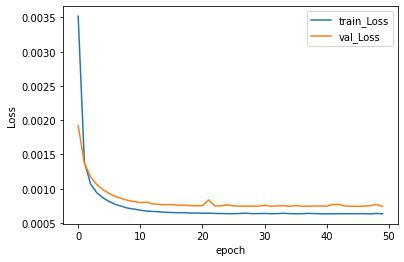

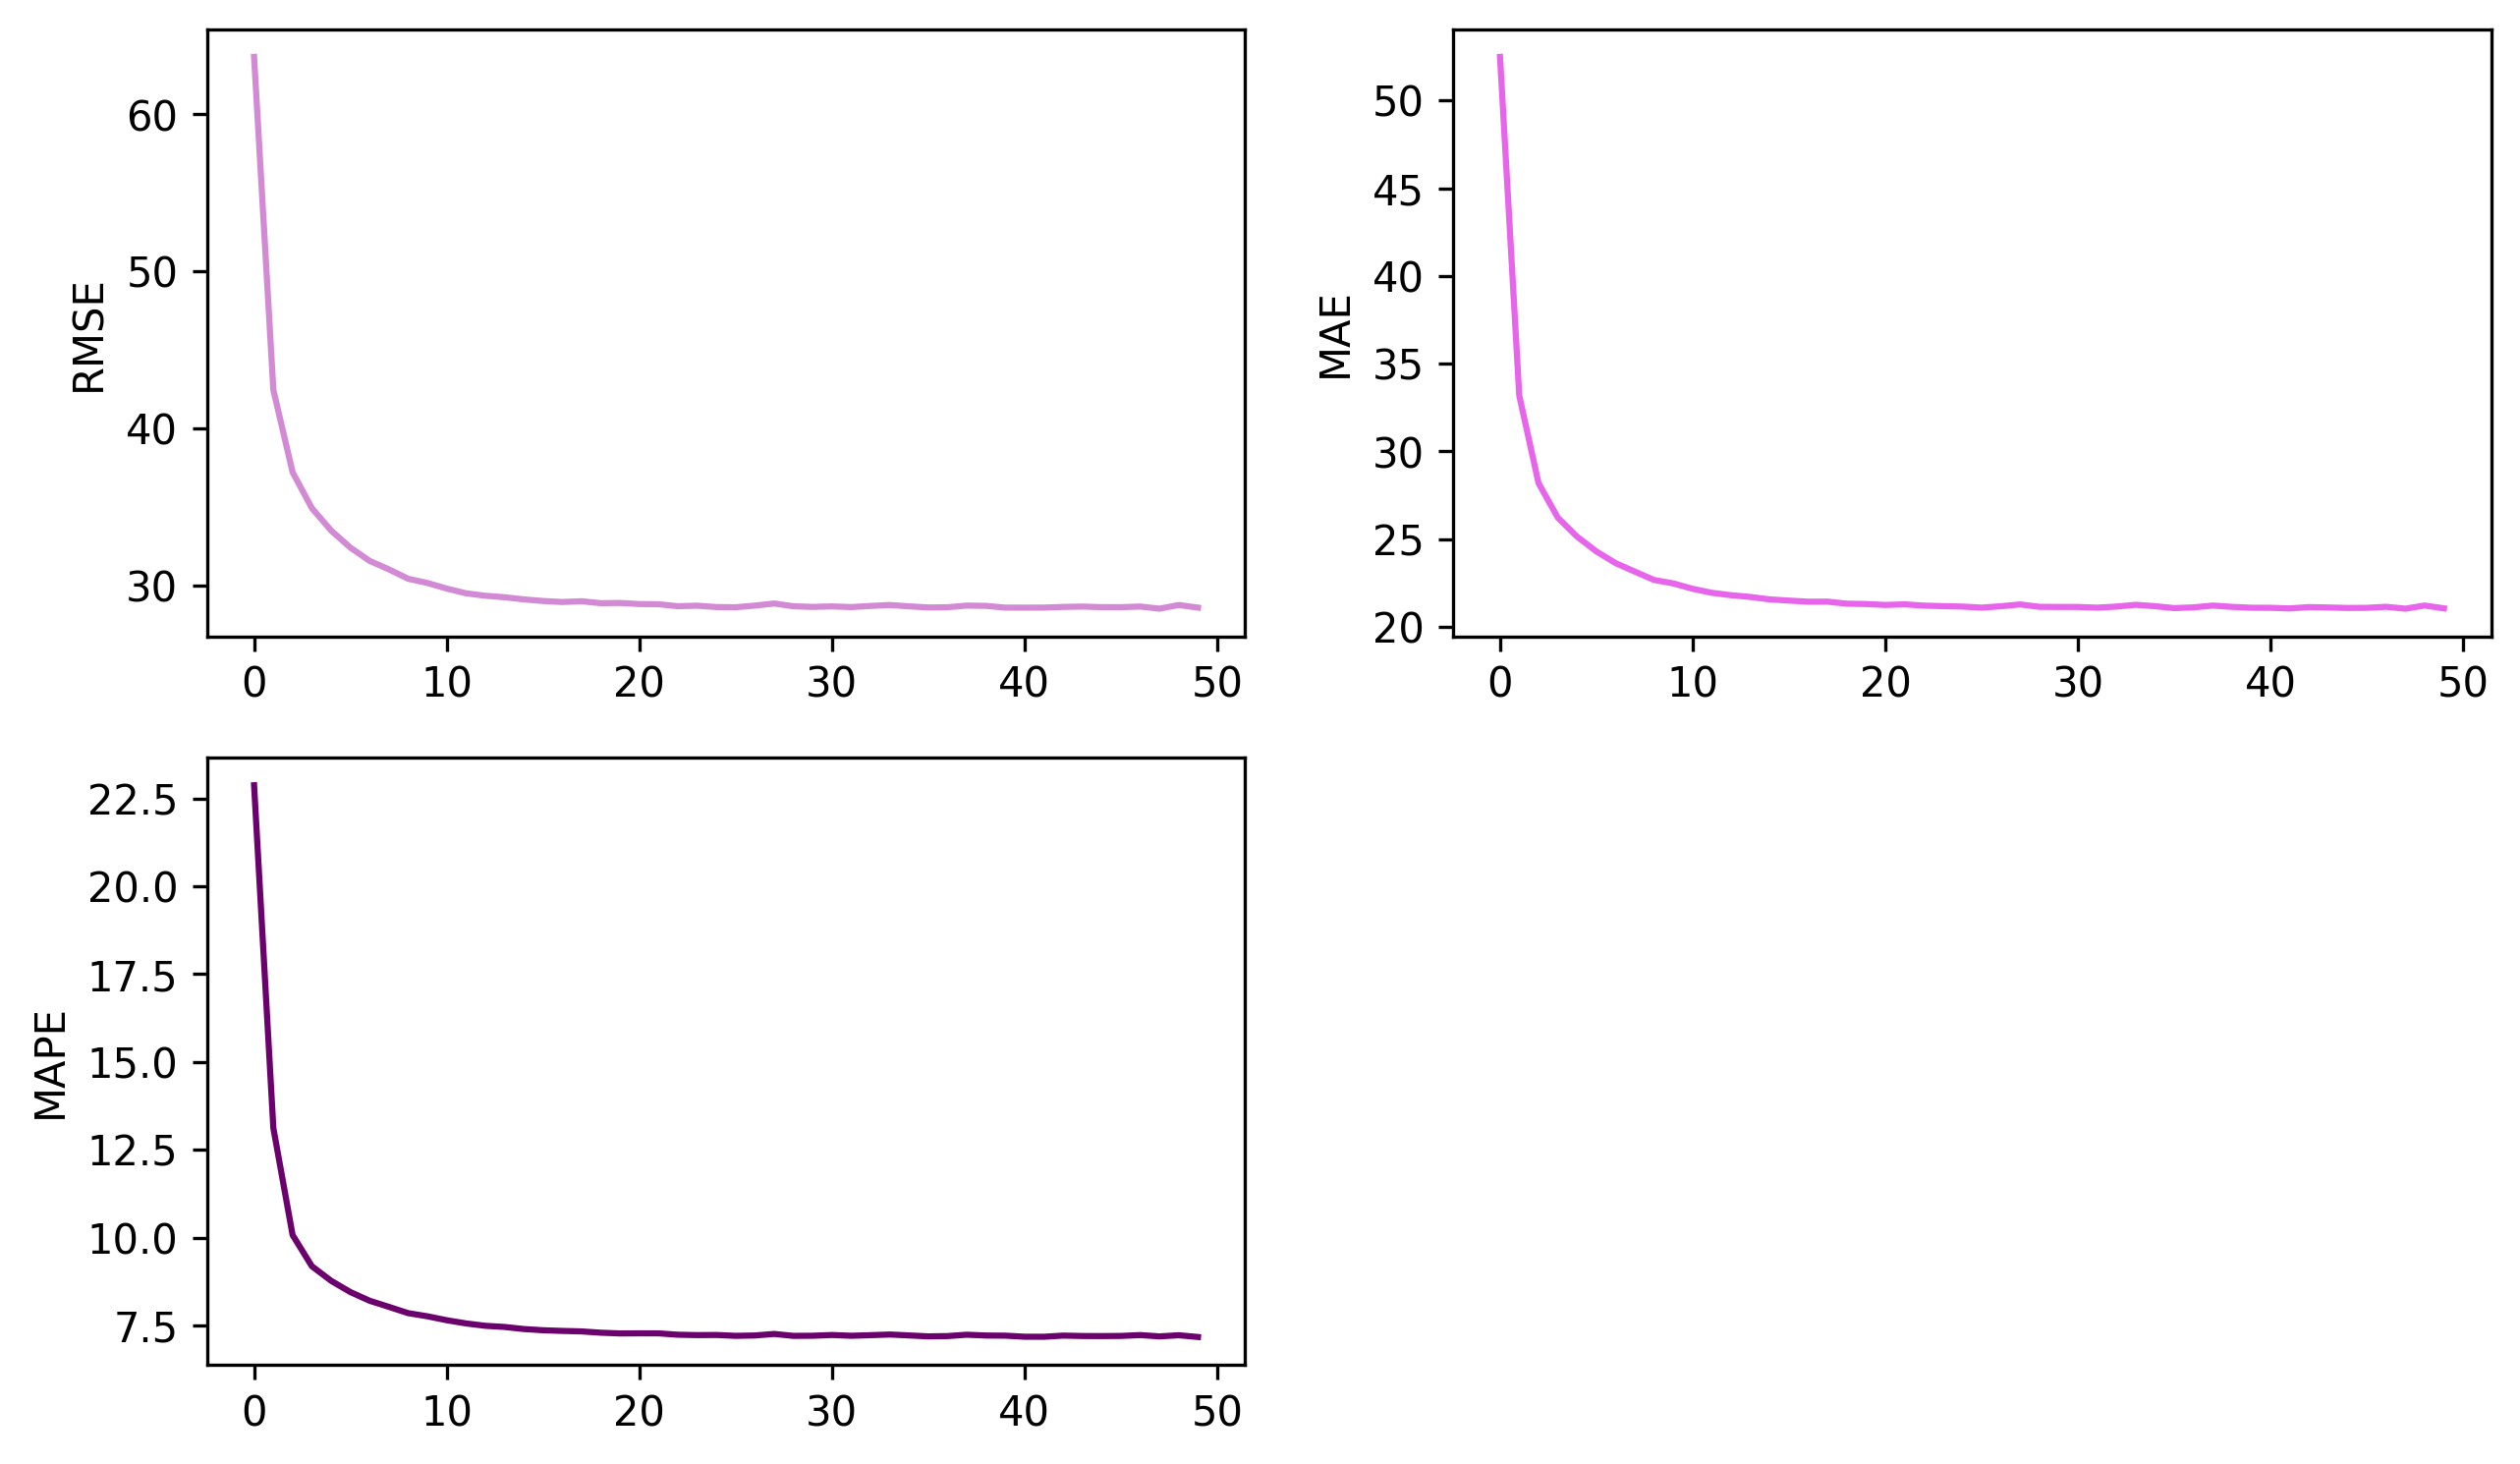

In [ ]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

In [ ]:
bi_rnn = nn.RNN(input_size=3, hidden_size=32, num_layers=1, bidirectional=True, batch_first=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 32
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 50
loss_func = nn.MSELoss()

nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                              loss_func, TrafficData.denormalize, optimizer, epochs,
                              early_stop=50, device=device, output_model=out_linear)

*** epoch1, train loss 0.0794, train rmse 306.4820, val loss 0.0177, val rmse 143.836678, time use 1.331s
*** epoch2, train loss 0.0161, train rmse 145.1718, val loss 0.0148, val rmse 132.768834, time use 0.424s
*** epoch3, train loss 0.0128, train rmse 129.3419, val loss 0.0108, val rmse 113.197368, time use 0.412s
*** epoch4, train loss 0.0072, train rmse 95.8332, val loss 0.0030, val rmse 62.028238, time use 0.712s
*** epoch5, train loss 0.0013, train rmse 41.4335, val loss 0.0013, val rmse 39.339734, time use 0.441s
*** epoch6, train loss 0.0011, train rmse 38.0491, val loss 0.0012, val rmse 39.031746, time use 0.423s
*** epoch7, train loss 0.0011, train rmse 37.5496, val loss 0.0012, val rmse 38.714609, time use 0.433s
*** epoch8, train loss 0.0011, train rmse 37.1412, val loss 0.0012, val rmse 38.375916, time use 0.430s
*** epoch9, train loss 0.0010, train rmse 36.8642, val loss 0.0012, val rmse 38.131098, time use 0.444s
*** epoch10, train loss 0.0010, train rmse 36.4746, val lo

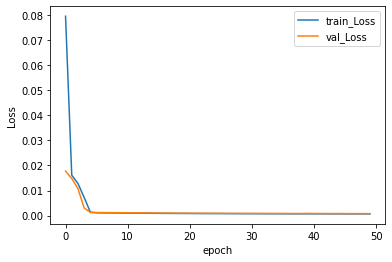

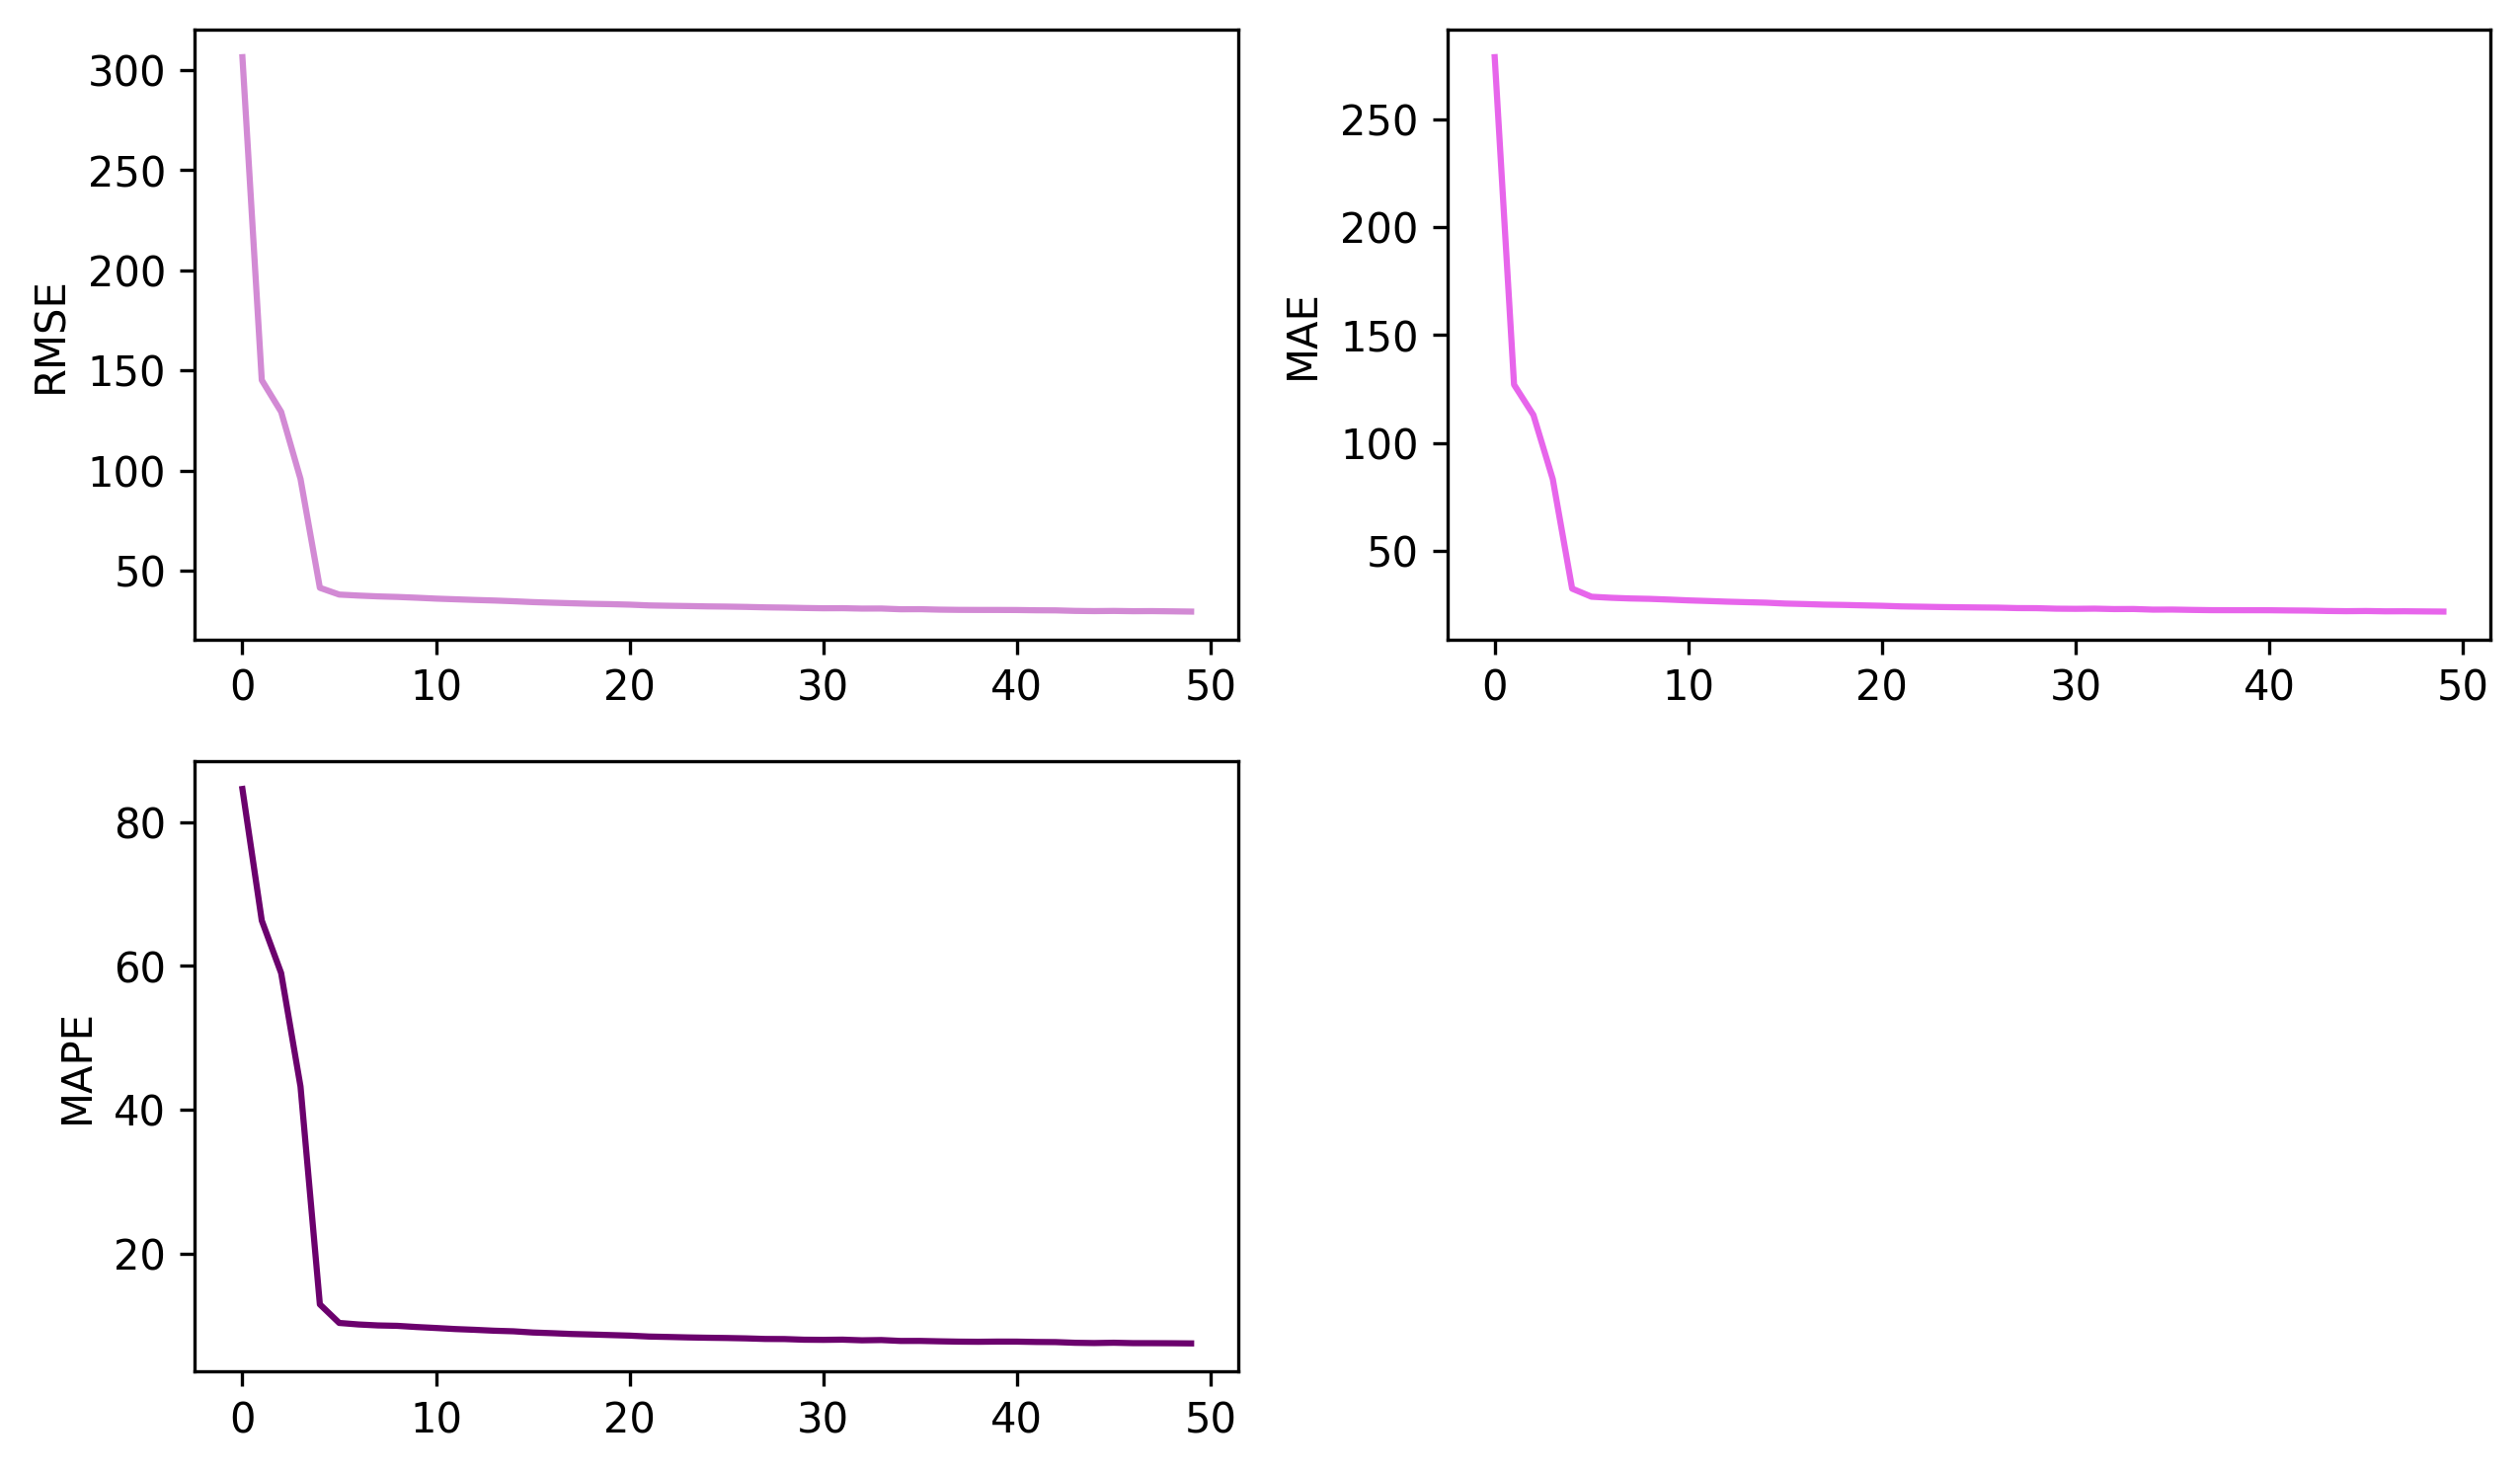

In [ ]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)